In [1]:
import nltk
import numpy
import pandas
import sklearn
import sklearn.pipeline
import sklearn.grid_search
import sklearn.decomposition

# all 3 lines below should be uncommented
import matplotlib.pyplot
%matplotlib inline
%matplotlib notebook

import sqlite3

import csshelper
import cssfeature
import csspipe
import csstransformer


db_path = './data.sqlite3'
sqlite_connection = sqlite3.connect(db_path)

In [2]:
data_reader_collection = [
        ('cExt', csshelper.CExtReader(sqlite_connection))
    
        , ('cNeu', csshelper.CNeuReader(sqlite_connection))
     
        , ('cAgr', csshelper.CAgrReader(sqlite_connection))
    
        , ('cCon', csshelper.CConReader(sqlite_connection))
    
        , ('cOpn', csshelper.COpnReader(sqlite_connection)) 
]

In [3]:
aggregator = csstransformer.Aggregator([
        csstransformer.PartOfSpeech(),
        csstransformer.SentenceLength(),
        csstransformer.NumberOfWords(),
        csstransformer.NumberOfCommas(),
        csstransformer.NumberOfDots(),
        csstransformer.NumberOfSemicolons(),
        csstransformer.NumberOfColons(),
        csstransformer.LexicalDiversity(),
        csstransformer.AverageWordLength(),
        csstransformer.NumberOfFunctionalWords(),
        csstransformer.NumberOfPronouns(),
        csstransformer.NumberOfPropnames(),
])

data = csshelper.CExtReader(sqlite_connection).get_results()

# aggregator.transform(data.sentence)

In [8]:
grid_parameter_collection = {
    'classifierLinearSVC': { 'features__status__tf_idf_vect__ngram_range': ((1, 1), (1, 2))},
#                            'features__derived_numeric__best': (5, 7,9, 10), 
    'classifierSVC': { 'features__status__tf_idf_vect__ngram_range': ((1, 1), (1, 2))},
#                      'features__derived_numeric__best': (5,7,9,10), 
     'classifierNB': { 'features__status__tf_idf_vect__ngram_range': ((1, 1), (1, 2))},
#                      'features__derived_numeric__best': (5, 7, 9, 10)},
    'classifierBNB': { 'features__status__tf_idf_vect__ngram_range': ((1, 1), (1, 2))}
#                      'features__derived_numeric__best': (5,7, 9, 10)},
}

base_pipeline = sklearn.pipeline.Pipeline([     
    ('features', sklearn.pipeline.FeatureUnion(
          transformer_list=[
           ('status', sklearn.pipeline.Pipeline([
              ('tf_idf_vect', sklearn.feature_extraction.text.TfidfVectorizer()),
            ])),
                  
            ('derived_string', sklearn.pipeline.Pipeline([
                ('part_of_speech', csstransformer.PartOfSpeech()),
                ('tf_idf_vect', sklearn.feature_extraction.text.TfidfVectorizer()),
            ])),
                 
                    
            ('derived_string (smileys)', sklearn.pipeline.Pipeline([
                ('smileys', csstransformer.Smileys()),
                ('tf_idf_vect', sklearn.feature_extraction.text.TfidfVectorizer(vocabulary=csstransformer.Smileys.smileys, 
                                                                                stop_words=None)),
            ])),

            
            ('derived_numeric', sklearn.pipeline.Pipeline([
              ('numeric_aggregator', csstransformer.Aggregator([
                    csstransformer.SentenceLength(),
                    csstransformer.NumberOfWords(),
                    csstransformer.NumberOfCommas(),
                    csstransformer.NumberOfDots(),
                    csstransformer.NumberOfSemicolons(),
                    csstransformer.NumberOfColons(),
                    csstransformer.LexicalDiversity(),
                    csstransformer.AverageWordLength(),
                    csstransformer.NumberOfFunctionalWords(),
                    csstransformer.NumberOfPronouns(),
                    csstransformer.NumberOfPropnames(),
                ])), 
              ('scaler', sklearn.preprocessing.MinMaxScaler()),
            ])),   
          ],
    )),
])

classifier_collection = [
        ('classifierLinearSVC', ('clf', sklearn.svm.LinearSVC(random_state = 5152))),
    
#         ('classifierSVC2Variante', ('clf', sklearn.svm.SVC(cache_size=4096, random_state = 5152, 
#                                                   kernel = "linear", decision_function_shape = "ovr", 
#                                                 probability=True))),
    
        ('classifierSVC', ('clf', sklearn.svm.SVC(cache_size=4096, random_state = 5152, 
                                                  kernel = "rbf", decision_function_shape = "ovr", 
                                                probability=True))),
        ('classifierNB', ('nb', sklearn.naive_bayes.MultinomialNB())),
        ('classifierBNB', ('bnb', sklearn.naive_bayes.BernoulliNB()))
]

def create_full_pipelines():
    return [
        (class_name, sklearn.pipeline.Pipeline(base_pipeline.steps + [classifier]))
        for class_name, classifier in classifier_collection
    ]

pipeline_collection = create_full_pipelines()


In [9]:
for pipe_name, pipe in pipeline_collection:
    print()
    print(pipe_name)
#     print(pipe.steps)


classifierLinearSVC

classifierSVC

classifierNB

classifierBNB


In [10]:
def plot_roc_curve(test_class, y_score, name, trait):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr, tpr, _ = sklearn.metrics.roc_curve(test_class, y_score[:, 1], pos_label=1)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    matplotlib.pyplot.plot([0, 1], [0, 1], 'k--')
    matplotlib.pyplot.xlim([0.0, 1.0])
    matplotlib.pyplot.ylim([0.0, 1.05])
    matplotlib.pyplot.xlabel('False Positive Rate')
    matplotlib.pyplot.ylabel('True Positive Rate')
    matplotlib.pyplot.title('ROC chart with ' + name + " algorithm and on " + trait + " dataset")
    matplotlib.pyplot.legend(loc="lower right")

    matplotlib.pyplot.show()

In [11]:
def apply_some_grid_search(pipe_name, pipeline, reader_description, reader):
    print("\nFOR: Pipeline: %s/%s" % (reader_description, pipe_name))

    data = reader.get_results()
    feature = data.iloc[:,0]
    label = data.iloc[:,1]

    grid_parameter = grid_parameter_collection[pipe_name]

    split = sklearn.cross_validation.train_test_split(feature, label, train_size=0.66, 
    stratify=label, random_state=5152)

    x_train, x_test, y_train, y_test = split

    grid_search = sklearn.grid_search.GridSearchCV(pipeline, param_grid=grid_parameter, 
                                                   cv=2, n_jobs=-1, verbose=0)

    grid_search.fit(x_train, y_train)
    y_pred_trait = grid_search.predict(x_test)


    if 'predict_proba' in dir(pipeline.steps[-1][-1]):
        print("it is in predict proba")
        y_score_trait = grid_search.predict_proba(x_test)
        plot_roc_curve(y_test, y_score_trait, "Pipeline", reader_description)
        
    # (un)comment below for confusion matrices
    print(sklearn.metrics.classification_report(y_test, y_pred_trait))
    print(sklearn.metrics.confusion_matrix(y_test, y_pred_trait))
    print("F1: ", sklearn.metrics.f1_score(y_test, y_pred_trait, average='binary'))
    print("Precision: ", sklearn.metrics.average_precision_score(y_test, y_pred_trait, average='micro'))
    print("Recall: ", sklearn.metrics.recall_score(y_test, y_pred_trait, average='binary'))
    print("Accuracy score: ", sklearn.metrics.accuracy_score(y_test, y_pred_trait))
    
    print("")

    print("GRID SEARCH:")
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(grid_parameter.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [14]:
#LinearSVC
pipe_name , pipeline = pipeline_collection[0]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierLinearSVC
             precision    recall  f1-score   support

      False       0.64      0.71      0.68      1941
       True       0.54      0.46      0.50      1431

avg / total       0.60      0.61      0.60      3372

[[1385  556]
 [ 773  658]]
F1:  0.497542533081
Precision:  0.615534500098
Recall:  0.459818308875
Accuracy score:  0.605871886121

GRID SEARCH:
Best score: 0.580
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cNeu/classifierLinearSVC
             precision    recall  f1-score   support

      False       0.66      0.81      0.73      2108
       True       0.50      0.32      0.39      1264

avg / total       0.60      0.62      0.60      3372

[[1699  409]
 [ 856  408]]
F1:  0.392119173474
Precision:  0.538014046894
Recall:  0.322784810127
Accuracy score:  0.624851720047

GRID SEARCH:
Best score: 0.618
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cA


FOR: Pipeline: cExt/classifierSVC
it is in predict proba


<IPython.core.display.Javascript object>


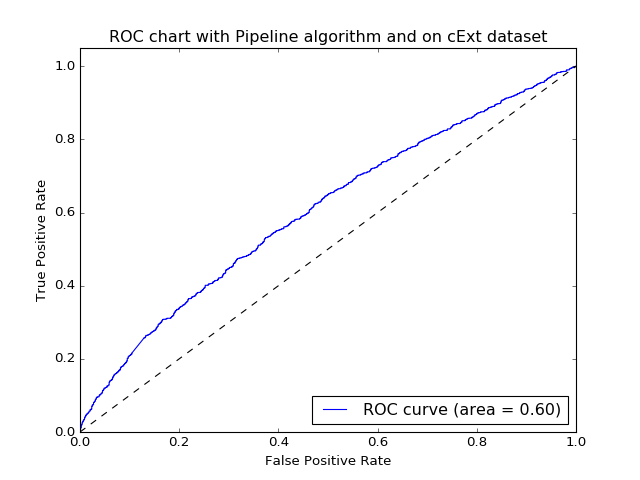

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      False       0.58      1.00      0.73      1941
       True       0.00      0.00      0.00      1431

avg / total       0.33      0.58      0.42      3372

[[1941    0]
 [1431    0]]
F1:  0.0
Precision:  0.7121886121
Recall:  0.0
Accuracy score:  0.575622775801

GRID SEARCH:
Best score: 0.575
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierSVC
it is in predict proba


<IPython.core.display.Javascript object>


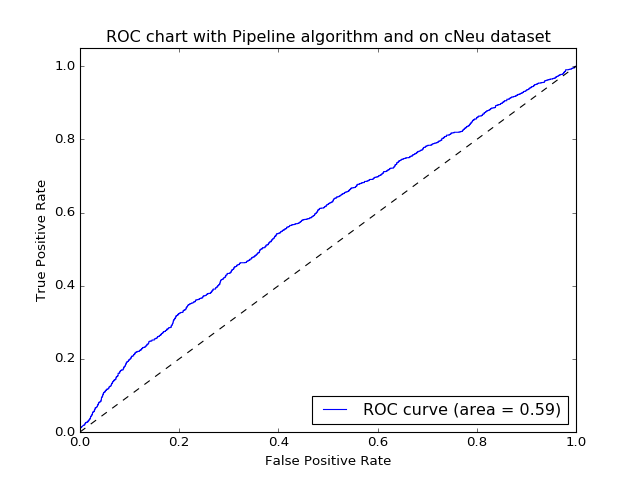

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      False       0.63      1.00      0.77      2108
       True       0.00      0.00      0.00      1264

avg / total       0.39      0.63      0.48      3372

[[2108    0]
 [1264    0]]
F1:  0.0
Precision:  0.687425860024
Recall:  0.0
Accuracy score:  0.625148279953

GRID SEARCH:
Best score: 0.625
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierSVC
it is in predict proba


<IPython.core.display.Javascript object>


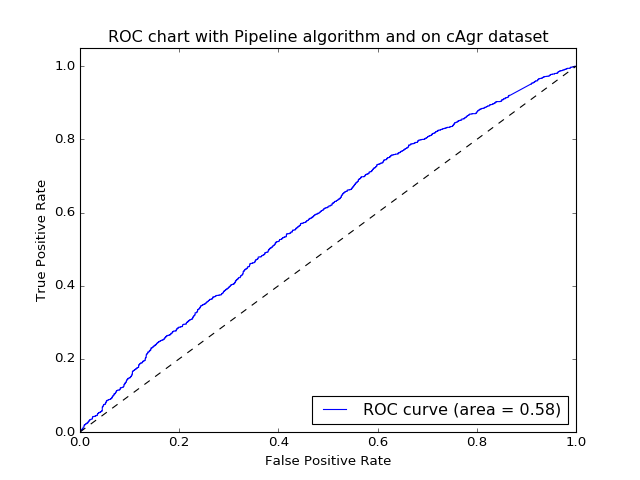

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      False       0.00      0.00      0.00      1581
       True       0.53      1.00      0.69      1791

avg / total       0.28      0.53      0.37      3372

[[   0 1581]
 [   0 1791]]
F1:  0.693782684486
Precision:  0.765569395018
Recall:  1.0
Accuracy score:  0.531138790036

GRID SEARCH:
Best score: 0.531
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierSVC
it is in predict proba


<IPython.core.display.Javascript object>


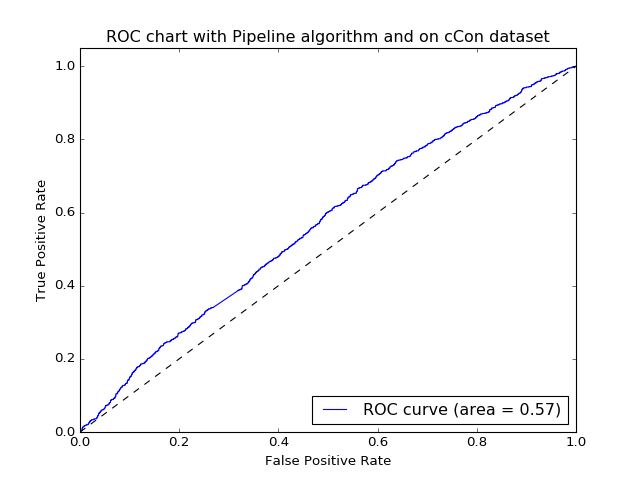

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      False       0.54      1.00      0.70      1823
       True       0.00      0.00      0.00      1549

avg / total       0.29      0.54      0.38      3372

[[1823    0]
 [1549    0]]
F1:  0.0
Precision:  0.729685646501
Recall:  0.0
Accuracy score:  0.540628706999

GRID SEARCH:
Best score: 0.541
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cOpn/classifierSVC
it is in predict proba


<IPython.core.display.Javascript object>


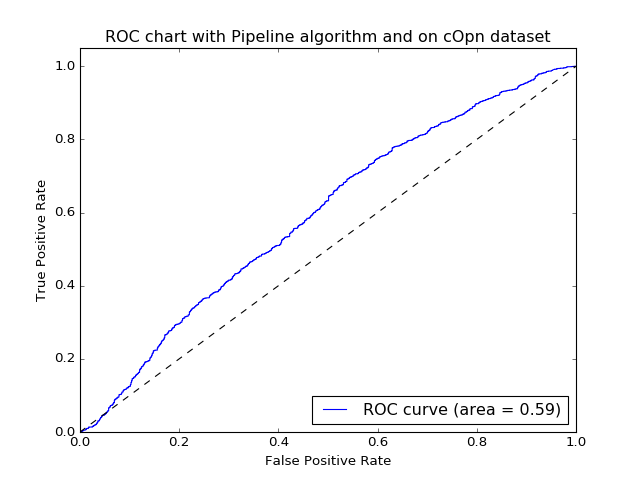

             precision    recall  f1-score   support

      False       0.00      0.00      0.00       866
       True       0.74      1.00      0.85      2506

avg / total       0.55      0.74      0.63      3372

[[   0  866]
 [   0 2506]]
F1:  0.852670976523
Precision:  0.871589561091
Recall:  1.0
Accuracy score:  0.743179122183

GRID SEARCH:
Best score: 0.743
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
#SVC
pipe_name , pipeline = pipeline_collection[1]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


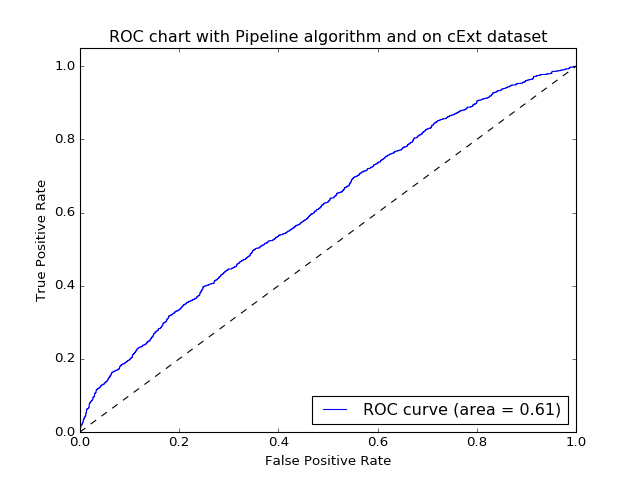

             precision    recall  f1-score   support

      False       0.59      0.97      0.74      1941
       True       0.71      0.10      0.17      1431

avg / total       0.64      0.60      0.50      3372

[[1884   57]
 [1290  141]]
F1:  0.173112338858
Precision:  0.59660799223
Recall:  0.0985324947589
Accuracy score:  0.600533807829

GRID SEARCH:
Best score: 0.591
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


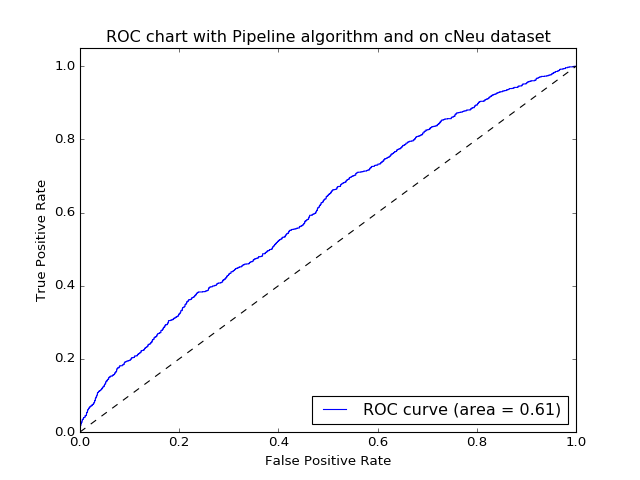

             precision    recall  f1-score   support

      False       0.63      1.00      0.77      2108
       True       0.86      0.02      0.05      1264

avg / total       0.72      0.63      0.50      3372

[[2103    5]
 [1233   31]]
F1:  0.0476923076923
Precision:  0.625647395278
Recall:  0.0245253164557
Accuracy score:  0.632858837485

GRID SEARCH:
Best score: 0.626
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


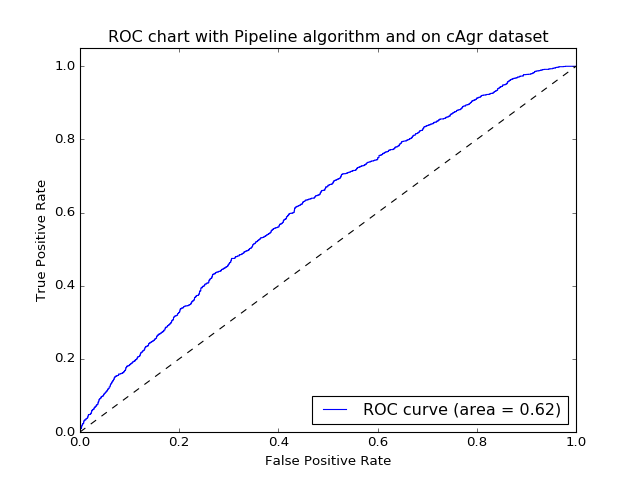

             precision    recall  f1-score   support

      False       0.64      0.24      0.35      1581
       True       0.57      0.88      0.69      1791

avg / total       0.60      0.58      0.53      3372

[[ 376 1205]
 [ 215 1576]]
F1:  0.689413823272
Precision:  0.755209168384
Recall:  0.879955332217
Accuracy score:  0.578884934757

GRID SEARCH:
Best score: 0.569
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


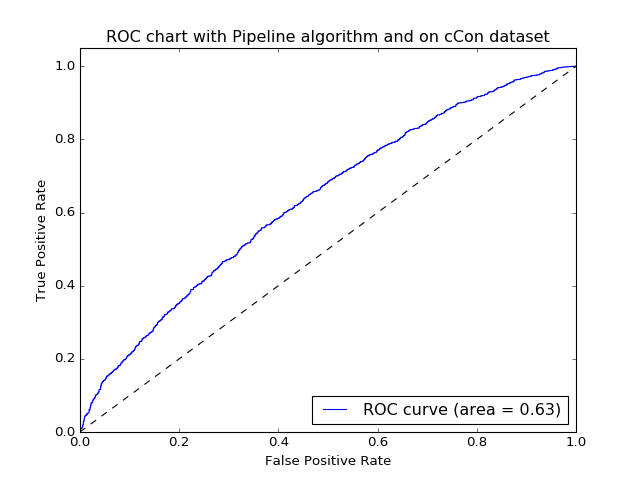

             precision    recall  f1-score   support

      False       0.58      0.88      0.70      1823
       True       0.63      0.24      0.35      1549

avg / total       0.60      0.59      0.54      3372

[[1605  218]
 [1175  374]]
F1:  0.349369453526
Precision:  0.610830369752
Recall:  0.241446094254
Accuracy score:  0.586892052195

GRID SEARCH:
Best score: 0.575
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cOpn/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


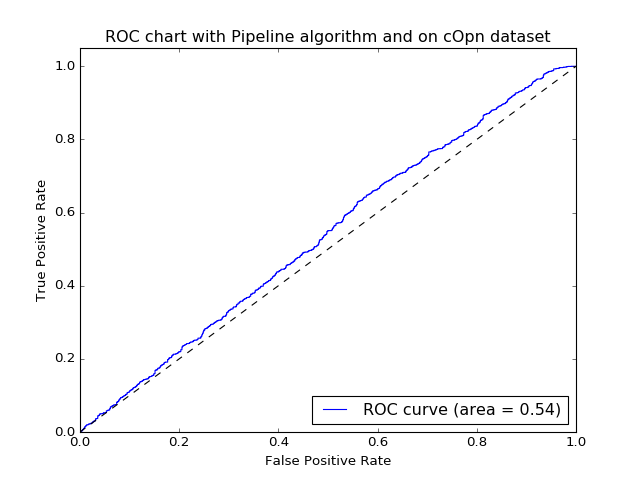

             precision    recall  f1-score   support

      False       1.00      0.00      0.00       866
       True       0.74      1.00      0.85      2506

avg / total       0.81      0.74      0.64      3372

[[   2  864]
 [   0 2506]]
F1:  0.852961198094
Precision:  0.871810089021
Recall:  1.0
Accuracy score:  0.743772241993

GRID SEARCH:
Best score: 0.743
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)


In [13]:
#MNB
pipe_name , pipeline = pipeline_collection[2]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


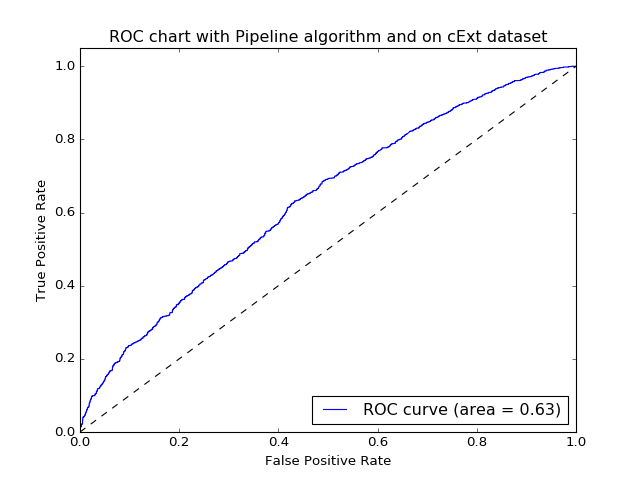

             precision    recall  f1-score   support

      False       0.62      0.84      0.71      1941
       True       0.58      0.30      0.39      1431

avg / total       0.60      0.61      0.58      3372

[[1639  302]
 [1008  423]]
F1:  0.392393320965
Precision:  0.58898907224
Recall:  0.295597484277
Accuracy score:  0.611506524318

GRID SEARCH:
Best score: 0.593
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


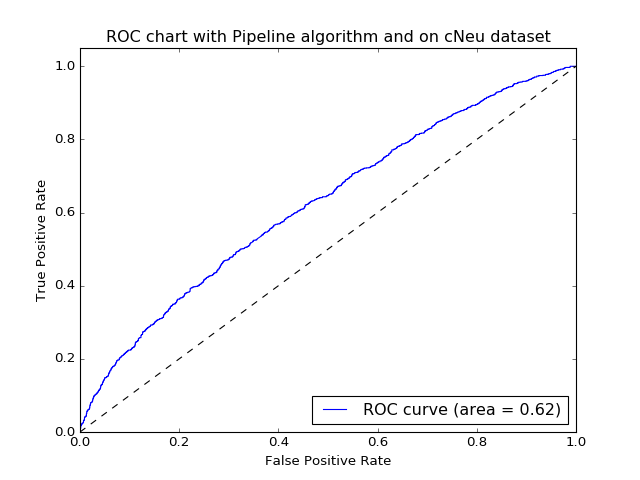

             precision    recall  f1-score   support

      False       0.65      0.94      0.77      2108
       True       0.62      0.15      0.24      1264

avg / total       0.64      0.65      0.57      3372

[[1990  118]
 [1072  192]]
F1:  0.243964421855
Precision:  0.544582895577
Recall:  0.151898734177
Accuracy score:  0.64709371293

GRID SEARCH:
Best score: 0.632
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


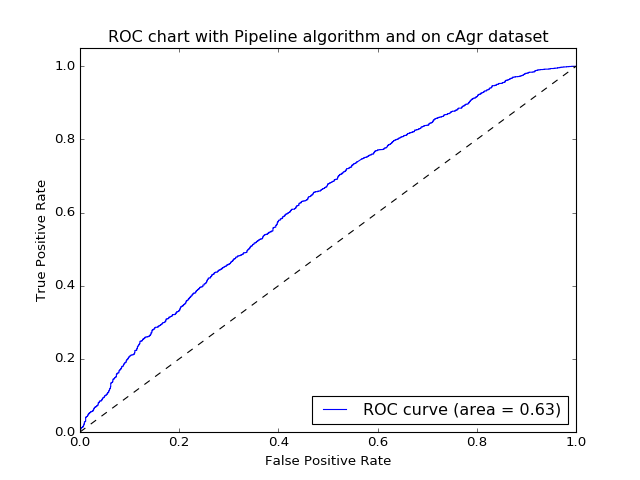

             precision    recall  f1-score   support

      False       0.60      0.41      0.49      1581
       True       0.59      0.76      0.67      1791

avg / total       0.60      0.60      0.58      3372

[[ 654  927]
 [ 433 1358]]
F1:  0.666339548577
Precision:  0.740478391783
Recall:  0.758235622557
Accuracy score:  0.596678529063

GRID SEARCH:
Best score: 0.571
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


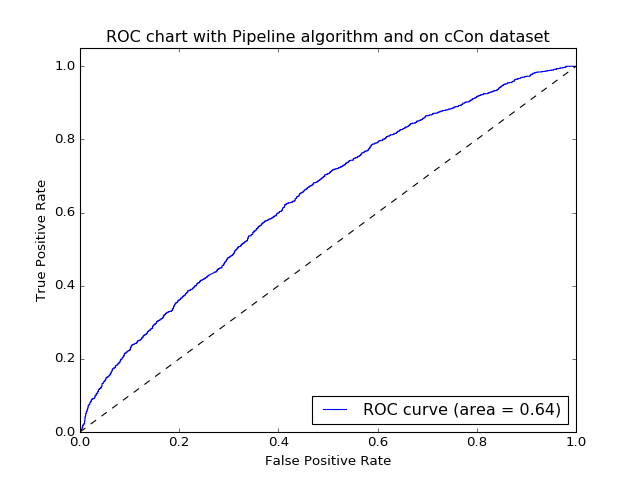

             precision    recall  f1-score   support

      False       0.62      0.68      0.65      1823
       True       0.57      0.50      0.53      1549

avg / total       0.60      0.60      0.60      3372

[[1246  577]
 [ 774  775]]
F1:  0.534298517752
Precision:  0.651542503758
Recall:  0.500322788896
Accuracy score:  0.599347568209

GRID SEARCH:
Best score: 0.582
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cOpn/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


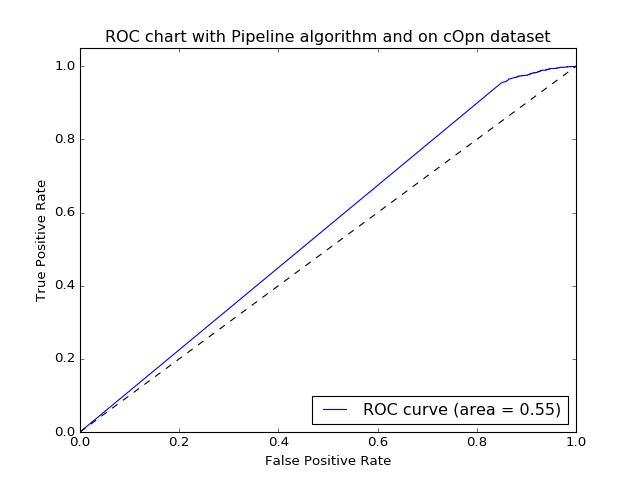

             precision    recall  f1-score   support

      False       0.83      0.02      0.03       866
       True       0.75      1.00      0.85      2506

avg / total       0.77      0.75      0.64      3372

[[  15  851]
 [   3 2503]]
F1:  0.854266211604
Precision:  0.872982829779
Recall:  0.998802873105
Accuracy score:  0.746737841044

GRID SEARCH:
Best score: 0.743
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 2)


In [12]:
#BNB
pipe_name , pipeline = pipeline_collection[3]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)

In [8]:
#BNB - very old
# pipe_name , pipeline = pipeline_collection[3]
    
# for reader_description, reader in data_reader_collection:
#     apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.390697674419
Precision:  0.588733878808
Recall:  0.293501048218
Accuracy score:  0.611506524318

GRID SEARCH:
Best score: 0.605
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.245859872611
Precision:  0.550512243015
Recall:  0.152689873418
Accuracy score:  0.648873072361

GRID SEARCH:
Best score: 0.641
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.664707323047
Precision:  0.739221805451
Recall:  0.757677275265
Accuracy score:  0.594009489917

GRID SEARCH:
Best score: 0.579
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.339568345324
Precision:  0.621685693101
Recall:  0.228534538412
Accuracy score:  0.591637010676

GRID SEARCH:
Best score: 0.592
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cOpn/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.854334854335
Precision:  0.877576297999
Recall:  0.971268954509
Accuracy score:  0.753855278766

GRID SEARCH:
Best score: 0.745
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)
